In [4]:
import sys
import os

import ipdb as pdb
import json
import random
import shutil
from termcolor import colored
import time

import torch
torch.backends.cudnn.enabled = True
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import h5py

import vr.utils as utils
import vr.preprocess
from vr.data import ClevrDataset, ClevrDataLoader
from vr.models.module_net import ModuleNet
from vr.models.seq2seq import Seq2Seq
from vr.models.baselines import LstmModel, CnnLstmModel, CnnLstmSaModel
from vr.models.filmed_net import FiLMedNet
from vr.models.film_gen import FiLMGen

In [2]:
def parse_int_list(s):
    if s == '': return ()
    return tuple(int(n) for n in s.split(','))

In [3]:
def get_state(m):
    if m is None:
        return None
    state = {}
    for k, v in m.state_dict().items():
        state[k] = v.clone()
    return state

In [4]:
def get_program_generator():
    vocab = utils.load_vocab(vocab_json)
    if program_generator_start_from is not None:
        pg, kwargs = utils.load_program_generator(
            program_generator_start_from, model_type=model_type)
        cur_vocab_size = pg.encoder_embed.weight.size(0)
        if cur_vocab_size != len(vocab['question_token_to_idx']):
            print('Expanding vocabulary of program generator')
            pg.expand_encoder_vocab(vocab['question_token_to_idx'])
            kwargs['encoder_vocab_size'] = len(vocab['question_token_to_idx'])
    else:
        kwargs = {
            'encoder_vocab_size': len(vocab['question_token_to_idx']),
            'decoder_vocab_size': len(vocab['program_token_to_idx']),
            'wordvec_dim': rnn_wordvec_dim,
            'hidden_dim': rnn_hidden_dim,
            'rnn_num_layers': rnn_num_layers,
            'rnn_dropout': rnn_dropout,
        }
        if model_type == 'FiLM':
            kwargs['parameter_efficient'] = program_generator_parameter_efficient == 1
            kwargs['output_batchnorm'] = rnn_output_batchnorm == 1
            kwargs['bidirectional'] = bidirectional == 1
            kwargs['encoder_type'] = encoder_type
            kwargs['decoder_type'] = decoder_type
            kwargs['gamma_option'] = gamma_option
            kwargs['gamma_baseline'] = gamma_baseline
            kwargs['num_modules'] = num_modules
            kwargs['module_num_layers'] = module_num_layers
            kwargs['module_dim'] = module_dim
            kwargs['debug_every'] = debug_every
            pg = FiLMGen(**kwargs)
        else:
            pg = Seq2Seq(**kwargs)
    pg.cuda()
    pg.train()
    return pg, kwargs

In [5]:
def get_execution_engine():
    vocab = utils.load_vocab(vocab_json)
    if execution_engine_start_from is not None:
        ee, kwargs = utils.load_execution_engine(
            execution_engine_start_from, model_type=model_type)
    else:
        kwargs = {
            'vocab': vocab,
            'feature_dim': parse_int_list(feature_dim),
            'stem_batchnorm': module_stem_batchnorm == 1,
            'stem_num_layers': module_stem_num_layers,
            'module_dim': module_dim,
            'module_residual': module_residual == 1,
            'module_batchnorm': module_batchnorm == 1,
            'classifier_proj_dim': classifier_proj_dim,
            'classifier_downsample': classifier_downsample,
            'classifier_fc_layers': parse_int_list(classifier_fc_dims),
            'classifier_batchnorm': classifier_batchnorm == 1,
            'classifier_dropout': classifier_dropout,
        }
        if model_type == 'FiLM':
            kwargs['num_modules'] = num_modules
            kwargs['stem_kernel_size'] = module_stem_kernel_size
            kwargs['stem_stride'] = module_stem_stride
            kwargs['stem_padding'] = module_stem_padding
            kwargs['module_num_layers'] = module_num_layers
            kwargs['module_batchnorm_affine'] = module_batchnorm_affine == 1
            kwargs['module_dropout'] = module_dropout
            kwargs['module_input_proj'] = module_input_proj
            kwargs['module_kernel_size'] = module_kernel_size
            kwargs['use_gamma'] = use_gamma == 1
            kwargs['use_beta'] = use_beta == 1
            kwargs['use_coords'] = use_coords
            kwargs['debug_every'] = debug_every
            kwargs['print_verbose_every'] = print_verbose_every
            kwargs['condition_method'] = condition_method
            kwargs['condition_pattern'] = parse_int_list(condition_pattern)
            ee = FiLMedNet(**kwargs)
        else:
            ee = ModuleNet(**kwargs)
    ee.cuda()
    ee.train()
    return ee, kwargs

In [6]:
def set_mode(mode, models):
    assert mode in ['train', 'eval']
    for m in models:
        if m is None: continue
        if mode == 'train': m.train()
        if mode == 'eval': m.eval()

In [7]:
def check_accuracy(program_generator, execution_engine, baseline_model, loader):
    set_mode('eval', [program_generator, execution_engine, baseline_model])
    num_correct, num_samples = 0, 0
    for batch in loader:
        questions, _, feats, answers, programs, _ = batch
        if isinstance(questions, list):
            questions = questions[0]

        questions_var = Variable(questions.cuda())
        feats_var = Variable(feats.cuda())
        answers_var = Variable(feats.cuda())
        if programs[0] is not None:
            programs_var = Variable(programs.cuda())

        scores = None  # Use this for everything but PG
        if model_type == 'PG':
            vocab = utils.load_vocab(vocab_json)
            for i in range(questions.size(0)):
                program_pred = program_generator.sample(Variable(questions[i:i+1].cuda(), volatile=True))
                program_pred_str = vr.preprocess.decode(program_pred, vocab['program_idx_to_token'])
                program_str = vr.preprocess.decode(programs[i], vocab['program_idx_to_token'])
                if program_pred_str == program_str:
                    num_correct += 1
                num_samples += 1
        elif model_type == 'EE':
            scores = execution_engine(feats_var, programs_var)
        elif model_type == 'PG+EE':
            programs_pred = program_generator.reinforce_sample(
                questions_var, argmax=True)
            scores = execution_engine(feats_var, programs_pred)
        elif model_type == 'FiLM':
            programs_pred = program_generator(questions_var)
            scores = execution_engine(feats_var, programs_pred)
        elif model_type in ['LSTM', 'CNN+LSTM', 'CNN+LSTM+SA']:
            scores = baseline_model(questions_var, feats_var)

        if scores is not None:
            _, preds = scores.data.cpu().max(1)
            num_correct += (preds == answers).sum()
            num_samples += preds.size(0)

        if num_val_samples is not None and num_samples >= num_val_samples:
            break

    set_mode('train', [program_generator, execution_engine, baseline_model])
    acc = float(num_correct) / num_samples
    return acc

In [8]:
def check_grad_num_nans(model, model_name='model'):
    grads = [p.grad for p in model.parameters() if p.grad is not None]
    num_nans = [np.sum(np.isnan(grad.data.cpu().numpy())) for grad in grads]
    nan_checks = [num_nan == 0 for num_nan in num_nans]
    if False in nan_checks:
        print('Nans in ' + model_name + ' gradient!')
        print(num_nans)
        pdb.set_trace()
        raise(Exception)

In [9]:
def train_loop(train_loader, val_loader):
    vocab = utils.load_vocab(vocab_json)
    program_generator, pg_kwargs, pg_optimizer = None, None, None
    execution_engine, ee_kwargs, ee_optimizer = None, None, None
    baseline_model, baseline_kwargs, baseline_optimizer = None, None, None
    baseline_type = None

    pg_best_state, ee_best_state, baseline_best_state = None, None, None
    
    optim_method = getattr(torch.optim, optimizer)
    
    if model_type in ['FiLM', 'PG', 'PG+EE']:
        program_generator, pg_kwargs = get_program_generator()
        pg_optimizer = optim_method(program_generator.parameters(),
                                    lr=learning_rate,
                                    weight_decay=weight_decay)
        print('Here is the conditioning network:')
        print(program_generator)
    
    if model_type in ['FiLM', 'EE', 'PG+EE']:
        execution_engine, ee_kwargs = get_execution_engine()
        ee_optimizer = optim_method(execution_engine.parameters(),
                                    lr=learning_rate,
                                    weight_decay=weight_decay)
        print('Here is the conditioned network:')
        print(execution_engine)
    
    loss_fn = torch.nn.CrossEntropyLoss().cuda()
    stats = {
        'train_losses': [],
        'train_rewards': [],
        'train_losses_ts': [],
        'train_accs': [],
        'val_accs': [],
        'val_accs_ts': [],
        'best_val_acc': -1,
        'model_t': 0,
    }
    
    t, epoch, reward_moving_average = 0, 0, 0
    
    set_mode('train', [program_generator, execution_engine, baseline_model])
    
    print('train_loader has %d samples' % len(train_loader.dataset))
    print('val_loader has %d samples' % len(val_loader.dataset))

    num_checkpoints = 0
    epoch_start_time = 0.0
    epoch_total_time = 0.0
    train_pass_total_time = 0.0
    val_pass_total_time = 0.0
    running_loss = 0.0
    
    while t < num_iterations:
        if (epoch > 0) and (use_time == 1):
            epoch_time = time.time() - epoch_start_time
            epoch_total_time += epoch_time
            print(colored('EPOCH PASS AVG TIME: ' + str(epoch_total_time / epoch), 'white'))
            print(colored('Epoch Pass Time      : ' + str(epoch_time), 'white'))
        epoch_start_time = time.time()

        epoch += 1
        print('Starting epoch %d' % epoch)
        for batch in train_loader:
            t += 1
            questions, _, feats, answers, programs, _ = batch
            if isinstance(questions, list):
                questions = questions[0]
            questions_var = Variable(questions.cuda())
            feats_var = Variable(feats.cuda())
            answers_var = Variable(answers.cuda())
            if programs[0] is not None:
                programs_var = Variable(programs.cuda())
            reward = None

            if model_type == 'FiLM':
                if set_execution_engine_eval == 1:
                    set_mode('eval', [execution_engine])
                programs_pred = program_generator(questions_var)
                scores = execution_engine(feats_var, programs_pred)
                loss = loss_fn(scores, answers_var)

                pg_optimizer.zero_grad()
                ee_optimizer.zero_grad()

                if debug_every <= -2:
                    pdb.set_trace()

                loss.backward()

                if debug_every < float('inf'):
                    check_grad_num_nans(execution_engine, 'FiLMedNet')
                    check_grad_num_nans(program_generator, 'FiLMGen')

                if train_program_generator == 1:
                    if grad_clip > 0:
                        torch.nn.utils.clip_grad_norm(program_generator.parameters(), grad_clip)
                    pg_optimizer.step()
                if train_execution_engine == 1:
                    if grad_clip > 0:
                        torch.nn.utils.clip_grad_norm(execution_engine.parameters(), grad_clip)
                    ee_optimizer.step()

            if t % record_loss_every == 0:
                running_loss += loss.item()
                avg_loss = running_loss / record_loss_every
                print(t, avg_loss)
                stats['train_losses'].append(avg_loss)
                stats['train_losses_ts'].append(t)
                if reward is not None:
                    stats['train_rewards'].append(reward)
                running_loss = 0.0
            else:
                running_loss += loss.item()

            if t % checkpoint_every == 0:
                num_checkpoints += 1
                print('Checking training accuracy ... ')
                start = time.time()
                with torch.no_grad():
                    train_acc = check_accuracy(program_generator, execution_engine,
                                               baseline_model, train_loader)
                if use_time == 1:
                    train_pass_time = (time.time() - start)
                    train_pass_total_time += train_pass_time
                    print(colored('TRAIN PASS AVG TIME: ' + str(train_pass_total_time / num_checkpoints), 'red'))
                    print(colored('Train Pass Time      : ' + str(train_pass_time), 'red'))
                print('train accuracy is', train_acc)
                print('Checking validation accuracy ...')
                start = time.time()
                with torch.no_grad():
                    val_acc = check_accuracy(program_generator, execution_engine,
                                             baseline_model, val_loader)
                if use_time == 1:
                    val_pass_time = (time.time() - start)
                    val_pass_total_time += val_pass_time
                    print(colored('VAL PASS AVG TIME:   ' + str(val_pass_total_time / num_checkpoints), 'cyan'))
                    print(colored('Val Pass Time        : ' + str(val_pass_time), 'cyan'))
                print('val accuracy is ', val_acc)
                stats['train_accs'].append(train_acc)
                stats['val_accs'].append(val_acc)
                stats['val_accs_ts'].append(t)

                if val_acc > stats['best_val_acc']:
                    stats['best_val_acc'] = val_acc
                    stats['model_t'] = t
                    best_pg_state = get_state(program_generator)
                    best_ee_state = get_state(execution_engine)
                    best_baseline_state = get_state(baseline_model)

                checkpoint = {
#                     'args': args.__dict__,
                    'program_generator_kwargs': pg_kwargs,
                    'program_generator_state': best_pg_state,
                    'execution_engine_kwargs': ee_kwargs,
                    'execution_engine_state': best_ee_state,
                    'baseline_kwargs': baseline_kwargs,
                    'baseline_state': best_baseline_state,
                    'baseline_type': baseline_type,
                    'vocab': vocab
                }

                for k, v in stats.items():
                    checkpoint[k] = v
                print('Saving checkpoint to %s' % checkpoint_path)
                torch.save(checkpoint, checkpoint_path)
                del checkpoint['program_generator_state']
                del checkpoint['execution_engine_state']
                del checkpoint['baseline_state']
                with open(checkpoint_path + '.json', 'w') as f:
                    json.dump(checkpoint, f)

            if t == num_iterations:
                break
    return stats

**===================================================== Args ===========================================================**

In [10]:
# Input data
train_questions_h5 = 'data/train_questions_math.h5'
train_features_h5 = 'data/train_features.h5'
val_questions_h5 = 'data/val_questions_math.h5'
val_features_h5 = 'data/val_features.h5'
feature_dim = '1024,14,14'
vocab_json = 'data/vocab_math.json'

loader_num_workers = 1
use_local_copies = 0
cleanup_local_copies = 1

family_split_file = None
num_train_samples = None
num_val_samples = 149991
shuffle_train_data = 1

# What type of model to use and which parts to train
model_type = 'FiLM'
#   choices=['FiLM', 'PG', 'EE', 'PG+EE', 'LSTM', 'CNN+LSTM', 'CNN+LSTM+SA']
train_program_generator = 1
train_execution_engine = 1
baseline_train_only_rnn = 0

# Start from an existing checkpoint
program_generator_start_from = None
execution_engine_start_from = None
baseline_start_from = None

# RNN options
rnn_wordvec_dim = 200
rnn_hidden_dim = 4096
rnn_num_layers = 1
rnn_dropout = 0

# Module net / FiLMedNet options
module_stem_num_layers = 1
module_stem_batchnorm = 1
module_dim = 128
module_residual = 1
module_batchnorm = 1

# FiLM only options
set_execution_engine_eval = 0
program_generator_parameter_efficient = 1
rnn_output_batchnorm = 0
bidirectional = 0
encoder_type = 'gru' 
#   choices=['linear', 'gru', 'lstm'])
decoder_type = 'linear' 
#   choices=['linear', 'gru', 'lstm'])
gamma_option = 'linear' 
#   choices=['linear', 'sigmoid', 'tanh', 'exp'])
gamma_baseline = 1
num_modules = 4
module_stem_kernel_size = 3
module_stem_stride = 1
module_stem_padding = None
module_num_layers = 1  # Only mnl=1 currently implemented
module_batchnorm_affine = 0  # 1 overrides other factors
module_dropout = 0e-2
module_input_proj = 1  # Inp conv kernel size (0 for None)
module_kernel_size = 3
condition_method = 'bn-film' 
#   choices=['block-input-film', 'block-output-film', 'bn-film', 'concat', 'conv-film', 'relu-film'])
condition_pattern = '1,1,1,1'  # List of 0/1's (len = # FiLMs)
use_gamma = 1
use_beta = 1
use_coords = 1  # 0: none, 1: low usage, 2: high usage
grad_clip = 0  # <= 0 for no grad clipping
debug_every = float('inf') # inf for no pdb
print_verbose_every = 200000  # inf for min print

# # CNN options (for baselines)
# cnn_res_block_dim = 128
# cnn_num_res_blocks = 0
# cnn_proj_dim = 512
# cnn_pooling = 'maxpool2',
# #   choices=['none', 'maxpool2'])

# # Stacked-Attention options
# stacked_attn_dim = 512
# num_stacked_attn = 2

# Classifier options
classifier_proj_dim = 512
classifier_downsample = 'maxpoolfull' 
#   choices=['maxpool2', 'maxpool3', 'maxpool4', 'maxpool5', 'maxpool7', 'maxpoolfull', 'none',
#            'avgpool2', 'avgpool3', 'avgpool4', 'avgpool5', 'avgpool7', 'avgpoolfull', 'aggressive'])
classifier_fc_dims = '1024'
classifier_batchnorm = 1
classifier_dropout = 0

# Optimization options
batch_size = 64
num_iterations = 200000
optimizer = 'Adam'
#   choices=['Adadelta', 'Adagrad', 'Adam', 'Adamax', 'ASGD', 'RMSprop', 'SGD'])
learning_rate = 3e-4
reward_decay = 0.9
weight_decay = 1e-5
                    
# Output options
checkpoint_path = "data/model/film_math.pt"
randomize_checkpoint_path = 0
avoid_checkpoint_override = 0
record_loss_every = 100
checkpoint_every = 10000
use_time = 0

**===================================================== Main ===========================================================**

In [11]:
if randomize_checkpoint_path == 1:
    name, ext = os.path.splitext(checkpoint_path)
    num = random.randint(1, 1000000)
    checkpoint_path = '%s_%06d%s' % (name, num, ext)
print('Will save checkpoints to %s' % checkpoint_path)

Will save checkpoints to data/model/film_math.pt


In [12]:
if use_local_copies == 1:
    shutil.copy(train_question_h5, '/tmp/train_questions.h5')
    shutil.copy(train_features_h5, '/tmp/train_features.h5')
    shutil.copy(val_question_h5, '/tmp/val_questions.h5')
    shutil.copy(val_features_h5, '/tmp/val_features.h5')
    train_question_h5 = '/tmp/train_questions.h5'
    train_features_h5 = '/tmp/train_features.h5'
    val_question_h5 = '/tmp/val_questions.h5'
    val_features_h5 = '/tmp/val_features.h5'

In [13]:
question_families = None
if family_split_file is not None:
    with open(family_split_file, 'r') as f:
        question_families = json.load(f)

In [14]:
vocab = utils.load_vocab(vocab_json)

train_loader_kwargs = {
    'question_h5': train_questions_h5,
    'feature_h5': train_features_h5,
    'vocab': vocab,
    'batch_size': batch_size,
    'shuffle': shuffle_train_data == 1,
#     'question_families': question_families,
#     'max_samples': num_train_samples,
#     'num_workers': loader_num_workers,
}

val_loader_kwargs = {
    'question_h5': val_questions_h5,
    'feature_h5': val_features_h5,
    'vocab': vocab,
    'batch_size': batch_size,
#     'question_families': question_families,
#     'max_samples': num_val_samples,
#     'num_workers': loader_num_workers,
}

In [15]:
train_loader = ClevrDataLoader(**train_loader_kwargs)
val_loader = ClevrDataLoader(**val_loader_kwargs)

Reading features from data/train_features.h5
Reading questions from  data/train_questions_math.h5
Reading question data into memory
Reading features from data/val_features.h5
Reading questions from  data/val_questions_math.h5
Reading question data into memory


In [16]:
stats = train_loop(train_loader, val_loader)

Here is the conditioning network:
FiLMGen(
  (encoder_embed): Embedding(82, 200)
  (encoder_rnn): GRU(200, 4096, batch_first=True)
  (decoder_linear): Linear(in_features=4096, out_features=1024, bias=True)
)
Here is the conditioned network:
FiLMedNet(
  (stem): Sequential(
    (0): Conv2d(1026, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (0): FiLMedResBlock(
    (input_proj): Conv2d(130, 128, kernel_size=(1, 1), stride=(1, 1))
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (film): FiLM()
  )
  (1): FiLMedResBlock(
    (input_proj): Conv2d(130, 128, kernel_size=(1, 1), stride=(1, 1))
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=Fa

22800 0.574912680387497
22900 0.5586186847090722
23000 0.5548975491523742
23100 0.5770105156302452
23200 0.5713976404070854
23300 0.5605930408835411
23400 0.5523869156837463
23500 0.5890571600198746
23600 0.5506158527731896
23700 0.5837684246897697
23800 0.5603250080347061
23900 0.5559361514449119
24000 0.5449283507466316
24100 0.555390015244484
24200 0.569185354411602
24300 0.5669895693659782
24400 0.5783711686730385
24500 0.5640866160392761
24600 0.5627270004153252
24700 0.5413700675964356
24800 0.5618614408373833
24900 0.5546207046508789
25000 0.5394153752923012
25100 0.5586318308115006
25200 0.5585264122486114
25300 0.5918846330046654
25400 0.5633101439476014
25500 0.562855390906334
25600 0.5436067208647728
25700 0.5686764985322952
25800 0.5482055231928825
25900 0.5589714542031288
26000 0.5509834924340248
Starting epoch 4
26100 0.5412688806653023
26200 0.5230500799417496
26300 0.5288744103908539
26400 0.5316849276423454
26500 0.5267586913704873
26600 0.5197381374239921
26700 0.5259

52900 0.4698239368200302
53000 0.44437451601028444
53100 0.4508705447614193
53200 0.44604318618774413
53300 0.48560458958148955
53400 0.4523563945293427
53500 0.4617521819472313
53600 0.45396023213863373
53700 0.4540890815854073
53800 0.44931265980005264
53900 0.43527291119098666
54000 0.4660844337940216
54100 0.45758654177188873
54200 0.47777737587690355
54300 0.4411366501450539
54400 0.46875108540058136
54500 0.44014250606298444
54600 0.44198165968060493
54700 0.46419002532958986
54800 0.455848528444767
54900 0.44438508808612825
55000 0.4540115597844124
55100 0.4323723569512367
55200 0.4486135913431644
55300 0.4574883469939232
55400 0.4444103169441223
55500 0.443323213160038
55600 0.4505819821357727
55700 0.4638723611831665
55800 0.44228016793727876
55900 0.44849582120776177
56000 0.45476325660943984
56100 0.45527489215135575
56200 0.4701317486166954
56300 0.4644684579968452
56400 0.465955550968647
56500 0.430952200293541
56600 0.4354857322573662
56700 0.46880117237567903
56800 0.465

82900 0.4522112759947777
83000 0.42234582871198656
83100 0.4194257684051991
83200 0.4290744233131409
83300 0.4304740107059479
83400 0.4189008918404579
83500 0.4144168868660927
83600 0.4170622391998768
83700 0.424998140335083
83800 0.417574273198843
83900 0.4432196271419525
84000 0.4140934003889561
84100 0.4167235919833183
84200 0.4207958661019802
84300 0.4305343219637871
84400 0.43158047407865524
84500 0.42350898295640943
84600 0.4278665940463543
84700 0.4089997236430645
84800 0.4451636774837971
84900 0.42795942664146425
85000 0.4234056740999222
85100 0.44188222333788874
85200 0.4070276176929474
85300 0.42194423869252207
85400 0.42120312035083773
85500 0.4121590481698513
85600 0.43090480208396914
85700 0.42741662919521334
85800 0.4238969461619854
85900 0.41778087854385376
86000 0.4257187870144844
86100 0.4061038637161255
86200 0.40639185175299647
86300 0.41848828852176667
86400 0.42262964710593226
86500 0.42309770196676255
86600 0.41696070820093156
86700 0.4231085827946663
86800 0.4220

112300 0.3992439742386341
112400 0.4034395691752434
112500 0.40489219784736635
112600 0.4156664377450943
112700 0.4127358010411262
112800 0.39852432399988175
112900 0.3894759291410446
Starting epoch 14
113000 0.40189621329307557
113100 0.3966036769747734
113200 0.3916488938033581
113300 0.3889678733050823
113400 0.3777130860090256
113500 0.3836165089905262
113600 0.3848440657556057
113700 0.40539916411042215
113800 0.38984434396028517
113900 0.3936101834475994
114000 0.3948123456537724
114100 0.39868498474359515
114200 0.3850926974415779
114300 0.389551876783371
114400 0.392475266456604
114500 0.3983844870328903
114600 0.3828989160060883
114700 0.41105694845318796
114800 0.3966979770362377
114900 0.4068869309127331
115000 0.38805114388465883
115100 0.3871077282726765
115200 0.3791252724826336
115300 0.3861184845864773
115400 0.4011360801756382
115500 0.39179461225867274
115600 0.37936622485518456
115700 0.3908137731254101
115800 0.38847487792372704
115900 0.38787836879491805
116000 0.3

141100 0.3954942084848881
141200 0.38505280390381813
141300 0.3869265341758728
141400 0.3854600462317467
141500 0.38443961918354036
141600 0.39247985497117044
141700 0.37482635289430616
141800 0.3868725150823593
141900 0.3857150276005268
142000 0.3837664088606834
142100 0.3946537671983242
142200 0.3885998021066189
142300 0.3785191251337528
142400 0.3954508602619171
142500 0.3940319034457207
142600 0.3816468335688114
142700 0.38900956317782404
142800 0.3682258163392544
142900 0.3726052261888981
143000 0.3787782272696495
143100 0.3804889810085297
143200 0.3739908272027969
143300 0.38922089487314226
143400 0.389820204526186
143500 0.37132157787680625
143600 0.40057132914662363
143700 0.4064414119720459
143800 0.39168217808008193
143900 0.39582106411457063
144000 0.3958954253792763
144100 0.38345867544412615
144200 0.3858236688375473
144300 0.3794091941416264
144400 0.3896316933631897
144500 0.37966328993439674
144600 0.38836490616202357
144700 0.3866758196055889
144800 0.37778215914964675

170100 0.36372686609625815
170200 0.3711743545532227
170300 0.3794113691151142
170400 0.3659576714038849
170500 0.37379316359758374
170600 0.36105911299586296
170700 0.3745960231125355
170800 0.37784193992614745
170900 0.38097649738192557
171000 0.3760730953514576
171100 0.366920131444931
171200 0.38479385286569595
171300 0.38188288390636443
171400 0.38223960280418395
171500 0.38290309965610503
171600 0.3657485669851303
171700 0.3730181495845318
171800 0.3781644020974636
171900 0.37510454520583153
172000 0.3740179269015789
172100 0.3775701902806759
172200 0.3777113223075867
172300 0.3795296157896519
172400 0.37704327747225763
172500 0.37598416149616243
172600 0.3745400878787041
172700 0.384194870442152
172800 0.3834910695254803
172900 0.38419425427913667
173000 0.3632891251146793
173100 0.38135739624500276
173200 0.3806484118103981
173300 0.37131561487913134
173400 0.38975113779306414
173500 0.37532848462462426
173600 0.375169592499733
173700 0.3950585015118122
Starting epoch 21
173800

199600 0.36909831061959264
199700 0.35687560841441157
199800 0.36488153129816053
Starting epoch 24
199900 0.34308056920766833
200000 0.35217028185725213
Checking training accuracy ... 
train accuracy is 0.8488827858361775
Checking validation accuracy ...
val accuracy is  0.8026207613966209
Saving checkpoint to data/model/film_math.pt


In [32]:
if use_local_copies == 1 and cleanup_local_copies == 1:
    os.remove('/tmp/train_questions.h5')
    os.remove('/tmp/train_features.h5')
    os.remove('/tmp/val_questions.h5')
    os.remove('/tmp/val_features.h5')

In [28]:
with open("data/stats/stats_math.json", "w") as outfile:
    json.dump(stats, outfile)

In [5]:
stats = json.load(open("data/stats/stats_math.json"))

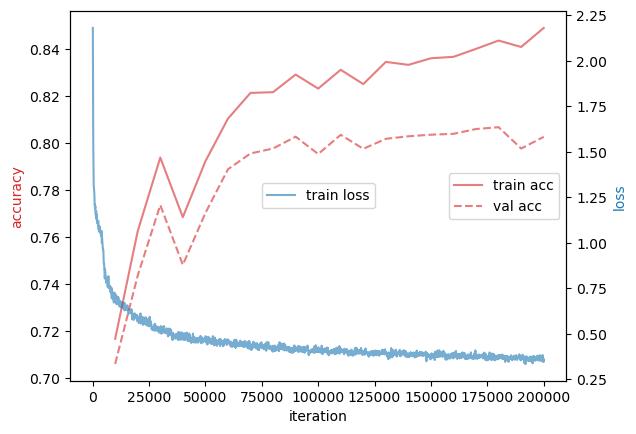

In [13]:
from matplotlib import pyplot as plt

fig, ax1 = plt.subplots()

color = '#d62728'
ax1.plot(stats['val_accs_ts'], stats['train_accs'], color=color, alpha=0.6, label='train acc')
ax1.plot(stats['val_accs_ts'], stats['val_accs'], linestyle='--', alpha=0.6, color=color, label='val acc')
ax1.set_xlabel('iteration')
ax1.set_ylabel('accuracy', color=color)
ax1.legend(loc='center right')

color = '#1f77b4'
ax2 = ax1.twinx()
ax2.plot(stats['train_losses_ts'], stats['train_losses'], color=color, alpha=0.6, label='train loss')
ax2.set_ylabel('loss', color=color)
ax2.legend(loc='center')

plt.show()

fig.savefig('data/stats/imgs/curves_math.png', dpi=1200)

In [35]:
print(stats['best_val_acc'])

0.8067230415597054
